<a href="https://colab.research.google.com/github/PARTH264/Fake-News-Detection/blob/main/Fake_News_Detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [2]:
# Import the necessary module from Google Colab to handle file uploads
from google.colab import files

# Open a file upload dialog in Google Colab to allow users to upload files
uploaded_files = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Create a hidden directory named '.kaggle' in the home directory if it doesn't already exist
!mkdir -p ~/.kaggle

# Move the 'kaggle.json' file (which contains API credentials) into the '.kaggle' directory
!mv kaggle.json ~/.kaggle/

# Set appropriate permissions for the 'kaggle.json' file to keep it secure
# This ensures that only the owner can read and write the file (600 permission)
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
# Use the Kaggle API to download the dataset from Kaggle
# The dataset ID 'saurabhshahane/fake-news-classification' refers to a Fake News Classification dataset
!kaggle datasets download -d saurabhshahane/fake-news-classification

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
License(s): Attribution 4.0 International (CC BY 4.0)


In [8]:
# Unzip the downloaded dataset (fake-news-classification.zip) to extract its contents
!unzip fake-news-classification.zip

Archive:  fake-news-classification.zip
replace WELFake_Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: WELFake_Dataset.csv     


In [9]:
df=pd.read_csv('WELFake_Dataset.csv')

In [10]:
# Display the first five rows of the dataset to get a quick overview of the data
df.head()  # This shows the first five rows of the DataFrame `df`

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [11]:
# Display a summary of the DataFrame, including column names, non-null counts, and data types
df.info()  # This provides a concise summary of the DataFrame, including memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [12]:
# Check for missing (NaN) values in the dataset and get the total count of missing values per column
df.isna().sum()  # This returns the number of missing values (NaN) for each column in the DataFrame

,0
Unnamed: 0,0
title,558
text,39
label,0


In [13]:
# Check for duplicate rows in the DataFrame and count how many duplicates exist
duplicates = df.duplicated().sum()  # 'duplicated()' returns a Boolean Series where True represents duplicate rows
print(f"Number of duplicate rows: {duplicates}")  # Print the number of duplicate rows

Number of duplicate rows: 0


In [14]:
# Check for duplicate rows in the DataFrame and count the total number of duplicates
duplicates = df.duplicated().sum()  # This counts the number of duplicated rows in the DataFrame
print(f"Number of duplicate rows: {duplicates}")  # Print the number of duplicate rows

# Fill missing values in the 'title' and 'text' columns with an empty string
df["title"].fillna("", inplace=True)  # Replace NaN values in the 'title' column with an empty string
df["text"].fillna("", inplace=True)   # Replace NaN values in the 'text' column with an empty string

# Check again for missing values after filling the 'title' and 'text' columns
df.isna().sum()  # Returns the number of missing values (NaN) per column in the DataFrame


Number of duplicate rows: 0


<ipython-input-14-c7893976dad3>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["title"].fillna("", inplace=True)  # Replace NaN values in the 'title' column with an empty string
<ipython-input-14-c7893976dad3>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

,0
Unnamed: 0,0
title,0
text,0
label,0


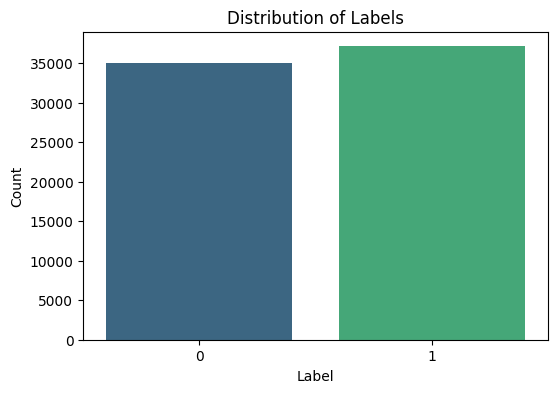

Label Counts:
 label
1    37106
0    35028
Name: count, dtype: int64


In [15]:
# Count the occurrences of each label in the 'label' column of the DataFrame
label_counts = df["label"].value_counts()  # This will return the count of each unique value in the 'label' column

# Set up the plot size
plt.figure(figsize=(6, 4))  # Defines the size of the plot (width x height)

# Create a barplot to visualize the distribution of labels
ax = sns.barplot(x=label_counts.index,  # x-axis: the unique labels
                 y=label_counts.values,  # y-axis: the count of each label
                 hue=label_counts.index,  # Color the bars based on the label
                 dodge=False,  # Combine bars for each label (instead of separate bars)
                 palette="viridis",  # Color palette for the bars
                 legend=False)  # Hide the legend

# Add labels and title to the plot
plt.xlabel("Label")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis
plt.title("Distribution of Labels")  # Title of the plot
plt.xticks(rotation=0)  # Ensure that x-axis labels are horizontal
plt.show()  # Display the plot

# Print the counts of each label
print("Label Counts:\n", label_counts)  # Display the value counts of the labels


# **Text Preprocessing and Cleaning Pipeline**


In [16]:
# Importing necessary libraries for text processing, natural language processing (NLP), and visualization

import re  # Regular expressions for text cleaning and pattern matching
from nltk.corpus import stopwords  # To access a list of common stopwords for text processing
from nltk.tokenize import word_tokenize  # For splitting text into individual words (tokenization)
from nltk.stem import WordNetLemmatizer  # For lemmatizing words (reducing them to their base form)
from textblob import TextBlob  # For sentiment analysis and text manipulation
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
from wordcloud import WordCloud  # For generating word clouds from text data
from sklearn.feature_extraction.text import CountVectorizer  # For converting text data into a matrix of token counts

In [17]:
lemmatizer = WordNetLemmatizer()

# Download NLTK resources
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    # 1: Lowercasing
    text = text.lower()

    # 2: Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 3: Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 4: Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # 6: Tokenization
    tokens = word_tokenize(text)

    # 6: Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in tokens])

    # 7: Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # 8: Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    return text
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

print(df[['text', 'cleaned_text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                text  \
0  No comment is expected from Barack Obama Membe...   
1     Did they post their votes for Hillary already?   
2   Now, most of the demonstrators gathered last ...   
3  A dozen politically active pastors came here f...   
4  The RS-28 Sarmat missile, dubbed Satan 2, will...   

                                        cleaned_text  
0  comment expected barack obama member fyf fukyo...  
1                          post vote hillary already  
2  demonstrator gathered last night exercising co...  
3  dozen politically active pastor came private d...  
4  r sarmat missile dubbed satan replace s fly mi...  


# **Word Cloud Visualization of Cleaned Text Data**

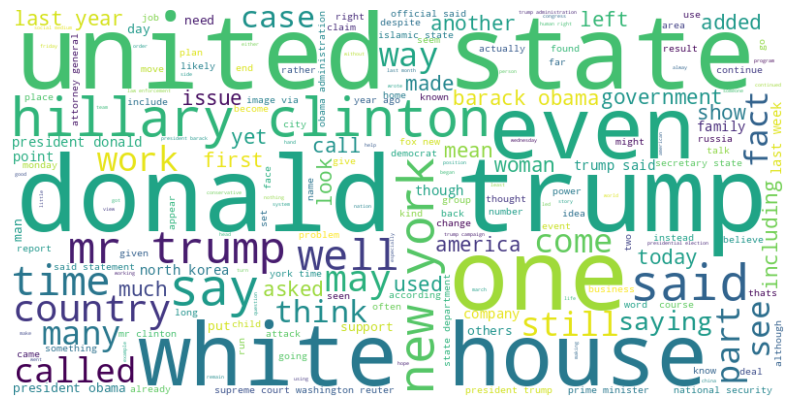

In [18]:
# Join all the cleaned text from the 'cleaned_text' column into a single string
# This creates a single string of all text data combined, with each piece of text separated by a space
all_text = ' '.join(df['cleaned_text'])

# Generate the word cloud using the WordCloud class
# Width and height set the size of the word cloud image
# background_color='white' sets the background color of the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Set up the plot size
plt.figure(figsize=(10, 6))

# Display the word cloud using imshow, which shows an image
# interpolation='bilinear' ensures the image is smoothly displayed
plt.imshow(wordcloud, interpolation='bilinear')

# Remove the axes of the plot (we don't need them for a word cloud)
plt.axis('off')

# Display the word cloud
plt.show()


# **Bag of Words (BoW) Feature Extraction**

In [19]:
# Initialize CountVectorizer with a maximum of 1000 features (words)
# This will only consider the top 1000 most frequent words in the cleaned text
count_vectorizer = CountVectorizer(max_features=1000)

# Fit the CountVectorizer to the 'cleaned_text' column and transform the text into a Bag of Words (BoW) representation
# This will return a sparse matrix where each row represents a text document (row in the DataFrame)
# and each column represents a word from the vocabulary with the frequency of that word in the document
bow_features = count_vectorizer.fit_transform(df['cleaned_text'])

# Convert the sparse matrix into a dense matrix and then into a DataFrame
# The columns of this DataFrame will be the words from the vocabulary, and the values will be the word frequencies in the documents
bow_df = pd.DataFrame(bow_features.toarray(), columns=count_vectorizer.get_feature_names_out())

# Display the first few rows of the Bag of Words DataFrame
# This shows the top 1000 words and their frequencies for the first few documents in the DataFrame
print("Bag of Words Features:\n", bow_df.head())

# Join the BoW features back to the original DataFrame
# Each word from the vocabulary will be added as a new column in the original DataFrame
# The 'rsuffix="_bow"' ensures that the new columns are named based on the word, with a '_bow' suffix
df = df.join(bow_df, rsuffix='_bow')

# Display the first few rows of the updated DataFrame which now contains both the original data and the new Bag of Words features
print(df.head())

Bag of Words Features:
    ability  able  access  according  account  accused  across  act  action  \
0        0     0       0          0        0        0       0    0       0   
1        0     0       0          0        0        0       0    0       0   
2        0     0       0          0        0        0       0    0       0   
3        0     0       0          0        0        0       0    1       3   
4        0     1       0          1        0        0       0    0       0   

   activist  ...  would  wrong  wrote  year  yearold  yes  yet  york  young  \
0         0  ...      2      0      0     0        0    0    0     0      1   
1         0  ...      0      0      0     0        0    0    0     0      0   
2         0  ...      0      0      0     0        0    0    0     0      0   
3         4  ...      4      0      0     4        0    0    1     0      1   
4         0  ...      1      0      0     0        0    0    0     0      0   

   youre  
0      0  
1      0  

In [20]:
# Print the column names of the bow_df DataFrame
# This will show the top 1000 words that were extracted from the cleaned text
print("Columns in bow_df:", bow_df.columns)

# Print the data types of each column in the bow_df DataFrame
# Since the word frequencies are numeric, all columns should have the data type 'int64' or 'float64'
print("Data types of bow_df:\n", bow_df.dtypes)


Columns in bow_df: Index(['ability', 'able', 'access', 'according', 'account', 'accused',
       'across', 'act', 'action', 'activist',
       ...
       'would', 'wrong', 'wrote', 'year', 'yearold', 'yes', 'yet', 'york',
       'young', 'youre'],
      dtype='object', length=1000)
Data types of bow_df:
 ability      int64
able         int64
access       int64
according    int64
account      int64
             ...  
yes          int64
yet          int64
york         int64
young        int64
youre        int64
Length: 1000, dtype: object


In [21]:
# Importing train_test_split from sklearn.model_selection to split the data into training and testing sets
from sklearn.model_selection import train_test_split

# Importing LogisticRegression from sklearn.linear_model to use logistic regression as a classification model
from sklearn.linear_model import LogisticRegression

# Importing accuracy_score and classification_report to evaluate the performance of the model
from sklearn.metrics import accuracy_score, classification_report

# Importing confusion_matrix to evaluate the model's performance using a confusion matrix
from sklearn.metrics import confusion_matrix


In [22]:
# Drop the columns that are not needed for the feature set (title, text, label, cleaned_text)
# 'X' will contain all the features (BoW features and others) for training the model
X = df.drop(columns=['title', 'text', 'label', 'cleaned_text'])

# Join the BoW features to the feature set 'X'
# 'bow_df' contains the top 1000 most frequent words from the cleaned text,
# and 'add_suffix('_bow')' ensures that each word column is named with the '_bow' suffix
X = X.join(bow_df.add_suffix('_bow'), how='inner')

# Assign the 'label' column to 'y', which will be the target variable (the class labels)
y = df['label']

# Split the data into training and testing sets
# The 'test_size=0.2' means 20% of the data will be used for testing, and the rest will be used for training
# 'random_state=42' ensures the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# Print the shape (dimensions) of the X_train dataset
# This will show the number of samples (rows) and the number of features (columns) in the training data
print("Shape of X_train:", X_train.shape)

# Print the shape (dimensions) of the X_test dataset
# This will show the number of samples (rows) and the number of features (columns) in the testing data
print("Shape of X_test:", X_test.shape)

# Print the shape (dimensions) of the y_train dataset
# This will show the number of training labels (rows), which should be the same as the number of samples in X_train
print("Shape of y_train:", y_train.shape)

# Print the shape (dimensions) of the y_test dataset
# This will show the number of testing labels (rows), which should be the same as the number of samples in X_test
print("Shape of y_test:", y_test.shape)


Shape of X_train: (57707, 2001)
Shape of X_test: (14427, 2001)
Shape of y_train: (57707,)
Shape of y_test: (14427,)


In [24]:
# After creating bow_df
bow_df = pd.DataFrame(bow_features.toarray(), columns=count_vectorizer.get_feature_names_out())

# First drop any existing _bow columns to prevent overlap
df = df.drop(columns=[col for col in df.columns if col.endswith('_bow')], errors='ignore')

# Now join with suffix
df = df.join(bow_df.add_suffix('_bow'))

# Prepare features
feature_columns = [col for col in df.columns if col not in ['title', 'text', 'label', 'cleaned_text']]
X = df[feature_columns]
y = df['label']

# Save feature information
joblib.dump(feature_columns, 'feature_columns.pkl')
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

In [25]:
import os
print("feature_columns.pkl exists:", os.path.exists('feature_columns.pkl'))
print("count_vectorizer.pkl exists:", os.path.exists('count_vectorizer.pkl'))

feature_columns.pkl exists: True
count_vectorizer.pkl exists: True


# **Machine learning Models**

# **Logistic Regression model**

In [26]:
# Import necessary libraries (make sure you've already imported these earlier in your script)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Logistic Regression model
# max_iter=1000 sets the maximum number of iterations for the solver to converge
# random_state=42 ensures reproducibility of results
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train (fit) the model on the training data (features: X_train, labels: y_train)
lr_model.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = lr_model.predict(X_test)

# Evaluate the model's accuracy by comparing predicted labels to actual test labels
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)  # Print the overall accuracy score

# Print a detailed classification report including precision, recall, F1-score, and support
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print the confusion matrix to show true positives, true negatives, false positives, and false negatives
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9359534206695779

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      7089
           1       0.93      0.95      0.94      7338

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427

Confusion Matrix:
 [[6552  537]
 [ 387 6951]]


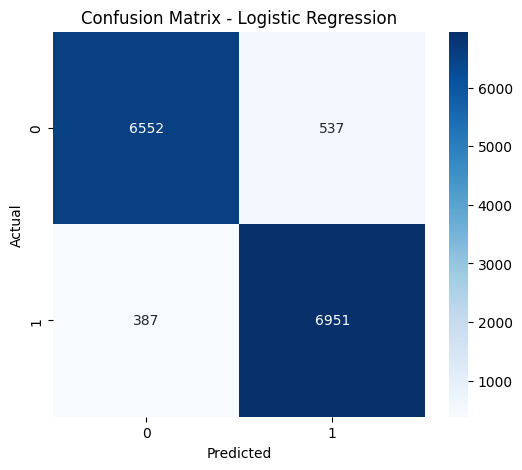

Model saved as 'logistic_regression_model.pkl'


In [27]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Save the trained model to a file
joblib.dump(lr_model, 'logistic_regression_model.pkl')
print("Model saved as 'logistic_regression_model.pkl'")


Mounted at /content/drive


['/content/drive/MyDrive/logistic_regression_model.pkl']

RANDOM FOREST

In [29]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest model:", accuracy_rf)

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy of Random Forest model: 0.9486379704720316

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      7089
           1       0.94      0.97      0.95      7338

    accuracy                           0.95     14427
   macro avg       0.95      0.95      0.95     14427
weighted avg       0.95      0.95      0.95     14427



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/random_forest_model.pkl']


Confusion Matrix:
 [[6599  490]
 [ 251 7087]]


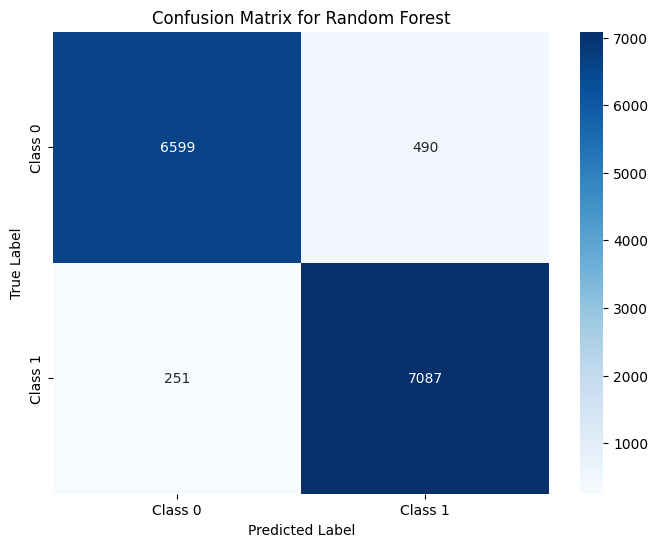

Random Forest model saved as 'random_forest_model.pkl'


In [31]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:\n", cm_rf)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save the Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Random Forest model saved as 'random_forest_model.pkl'")

In [32]:
# During training
count_vectorizer = CountVectorizer(max_features=1000)
bow_features = count_vectorizer.fit_transform(df['cleaned_text'])

# MUST save this to recreate the same features later
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

# **Deep Learning Models**

In [33]:
# Preprocessing the Text Data
tokenizer = Tokenizer(num_words=2000, lower=True)
tokenizer.fit_on_texts(df['cleaned_text'])
X = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad sequences to ensure uniform input length
X = pad_sequences(X, maxlen=50)

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(df['label'])

#  Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Build the LSTM Model
model = Sequential()

# Add an Embedding layer for text representation
model.add(Embedding(input_dim=2000, output_dim=32))

# Add Spatial Dropout to prevent overfitting
model.add(SpatialDropout1D(0.2))

# Add an LSTM layer with fewer units
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))

# Add a Dense layer for classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the Model with further reduced epochs and batch_size
history = model.fit(X_train, y_train, epochs=2, batch_size=16, validation_data=(X_test, y_test), verbose=1)

#  Evaluate the Model
y_pred_lstm = (model.predict(X_test) > 0.5).astype("int32")

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("Accuracy of LSTM model:", accuracy_lstm)

print("\nClassification Report:\n", classification_report(y_test, y_pred_lstm))

Epoch 1/2
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 199s 53ms/step - accuracy: 0.8522 - loss: 0.3473 - val_accuracy: 0.9015 - val_loss: 0.2431
Epoch 2/2
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 190s 53ms/step - accuracy: 0.9088 - loss: 0.2348 - val_accuracy: 0.9105 - val_loss: 0.2296
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
Accuracy of LSTM model: 0.9105150065848756

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      7089
           1       0.91      0.92      0.91      7338

    accuracy                           0.91     14427
   macro avg       0.91      0.91      0.91     14427
weighted avg       0.91      0.91      0.91     14427



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


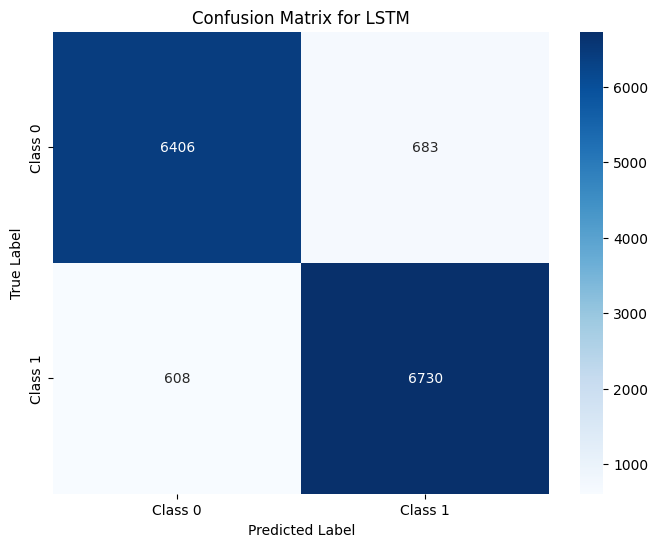

LSTM model saved as 'lstm_model.keras'


In [42]:
# Confusion Matrix and Plot
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save the model using Keras
model.save('lstm_model.keras')
print("LSTM model saved as 'lstm_model.keras'")

In [36]:
# Save the Tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')
print("Tokenizer saved as 'tokenizer.pkl'")

# Save the Label Encoder
joblib.dump(le, 'label_encoder.pkl')
print("Label Encoder saved as 'label_encoder.pkl'")

Tokenizer saved as 'tokenizer.pkl'
Label Encoder saved as 'label_encoder.pkl'


# **Fake News Detection System with Multi-Model Analysis and Interactive Interface**

In [37]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML
import ipywidgets as widgets

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Load Resources & Preprocessing**

In [45]:
# Load models and preprocessing resources with error handling
def load_resources():
    resources = {
        'models': {},           # Dictionary to store model objects
        'loaded_models': []     # List of successfully loaded model names
    }

    try:
        # Define expected model files
        model_files = {
            'Logistic Regression': 'logistic_regression_model.pkl',
            'Random Forest': 'random_forest_model.pkl'
        }

        # Attempt to load each traditional ML model
        for name, file in model_files.items():
            try:
                resources['models'][name] = joblib.load(file)
                resources['loaded_models'].append(name)
            except Exception as e:
                print(f"Warning: Could not load {name} model - {str(e)}")

        # Attempt to load LSTM model and its preprocessing tools
        try:
            resources['models']['LSTM'] = load_model('lstm_model.h5')
            resources['tokenizer'] = joblib.load('tokenizer.pkl')
            resources['label_encoder'] = joblib.load('label_encoder.pkl')
            resources['loaded_models'].append('LSTM')
        except Exception as e:
            print(f"Warning: Could not load LSTM components - {str(e)}")

        # Attempt to load additional feature preprocessing objects
        try:
            resources['count_vectorizer'] = joblib.load('count_vectorizer.pkl')
            resources['feature_columns'] = joblib.load('feature_columns.pkl')
        except Exception as e:
            print(f"Warning: Could not load feature preprocessing objects - {str(e)}")

    except Exception as e:
        print(f"Error loading resources: {e}")

    # Summary of successfully loaded models
    print(f"Successfully loaded models: {resources['loaded_models']}")
    return resources

# Load resources when script runs
resources = load_resources()


Successfully loaded models: ['Logistic Regression', 'Random Forest', 'LSTM']


# **Text Cleaning and Feature Preparation**

In [39]:
# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess input text
def clean_text(text):
    if not isinstance(text, str):
        return ""

    original_text = text  # Keep original for reference
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Tokenize and lemmatize words
    tokens = word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in tokens])

    # Remove URLs, mentions, hashtags, and non-ASCII characters
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+|#\w+|[^\x00-\x7F]+', '', text)

    return original_text, text

# Prepare features for traditional ML models (e.g. Logistic Regression, Random Forest)
def prepare_traditional_features(cleaned_text):
    try:
        # Ensure required preprocessing resources are available
        if 'count_vectorizer' not in resources or 'feature_columns' not in resources:
            raise ValueError("Required preprocessing resources not loaded")

        # Transform text to bag-of-words features
        bow_features = resources['count_vectorizer'].transform([cleaned_text])
        bow_df = pd.DataFrame(
            bow_features.toarray(),
            columns=[f"{col}_bow" for col in resources['count_vectorizer'].get_feature_names_out()]
        )

        # Initialize feature DataFrame with all expected columns
        features = pd.DataFrame(columns=resources['feature_columns'])
        features.loc[0] = 0  # Set all features to 0 initially

        # Fill in available BOW features
        for col in bow_df.columns:
            if col in features.columns:
                features[col] = bow_df[col]

        return features

    except Exception as e:
        print(f"Feature preparation error: {e}")
        return None

# Prepare input sequence for LSTM model
def prepare_lstm_input(cleaned_text):
    try:
        # Convert text to token sequence and pad it to fixed length
        sequence = resources['tokenizer'].texts_to_sequences([cleaned_text])
        return pad_sequences(sequence, maxlen=50)
    except Exception as e:
        print(f"LSTM input preparation error: {e}")
        return None


# **Prediction & Visualization Functions**

In [43]:
# Make prediction using a given model (traditional ML or LSTM)
def predict_with_model(model, features, model_type='traditional'):
    if model_type == 'traditional':
        pred = model.predict(features)[0]           # Predicted label (0 or 1)
        proba = model.predict_proba(features)[0]    # Probability for each class
        return {
            'prediction': 'Real' if pred == 1 else 'Fake',
            'confidence': f"{max(proba)*100:.1f}%", # Confidence based on higher prob
            'real_prob': f"{proba[1]*100:.1f}%",     # Probability of being Real
            'fake_prob': f"{proba[0]*100:.1f}%"      # Probability of being Fake
        }
    else:
        pred = model.predict(features)[0][0]         # LSTM returns a float prediction
        return {
            'prediction': 'Real' if pred > 0.5 else 'Fake',
            'confidence': f"{pred*100:.1f}%" if pred > 0.5 else f"{(1-pred)*100:.1f}%",
            'real_prob': f"{pred*100:.1f}%",
            'fake_prob': f"{(1-pred)*100:.1f}%"
        }

# Plot confidence levels for predictions from multiple models
def plot_confidence(results_df):
    plt.figure(figsize=(10, 5))

    # Color bars based on prediction outcome
    colors = ['green' if pred == 'Real' else 'red' for pred in results_df['Prediction']]

    # Extract numeric confidence values
    confidences = results_df['Confidence'].str.replace('%', '').astype(float)

    # Create bar plot
    bars = plt.bar(results_df['Model'], confidences, color=colors)

    plt.title('Model Confidence Levels', pad=20)
    plt.ylabel('Confidence (%)')
    plt.ylim(0, 110)

    # Add text labels above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom')

    # Custom legend
    real_patch = plt.Rectangle((0,0),1,1,fc="green")
    fake_patch = plt.Rectangle((0,0),1,1,fc="red")
    plt.legend([real_patch, fake_patch], ["Real", "Fake"], loc='upper right')

    plt.tight_layout()
    plt.show()


# **Interactive UI & Integration**

In [44]:
# Input area for news text
text_input = widgets.Textarea(
    value='',
    placeholder='Paste news article here...',
    layout={'width': '100%', 'height': '200px'},
    description='Input:'
)

# Analyze button
analyze_button = widgets.Button(
    description="Analyze",
    button_style='success',
    tooltip='Click to analyze the text'
)

# Output display area
output_area = widgets.Output()

# Define analysis logic
def on_button_click(b):
    with output_area:
        output_area.clear_output()
        text = text_input.value.strip()

        if not text:
            display(HTML("<div style='color:red; padding:10px;'>Please enter some text to analyze.</div>"))
            return

        try:
            original_text, cleaned_text = clean_text(text)

            display(HTML("<h3 style='color:#1a5276;'>Text Processing</h3>"))
            display(HTML("<b>Original:</b>"))
            display(HTML(f"<div style='background:#f8f9fa; padding:10px; border-radius:5px;'>{original_text}</div>"))
            display(HTML("<b>Cleaned:</b>"))
            display(HTML(f"<div style='background:#f8f9fa; padding:10px; border-radius:5px;'>{cleaned_text}</div>"))

            results = []
            available_models = []

            # Traditional models
            if all(k in resources for k in ['count_vectorizer', 'feature_columns']):
                features = prepare_traditional_features(cleaned_text)
                if features is not None:
                    for name in ['Logistic Regression', 'Decision Tree', 'Random Forest']:
                        if name in resources['models']:
                            try:
                                result = predict_with_model(resources['models'][name], features)
                                results.append({
                                    'Model': name,
                                    'Prediction': result['prediction'],
                                    'Real Probability': result['real_prob'],
                                    'Fake Probability': result['fake_prob'],
                                    'Confidence': result['confidence'],
                                    'Confidence_Value': float(result['confidence'].replace('%', ''))
                                })
                                available_models.append(name)
                            except Exception as e:
                                print(f"Error with {name}: {str(e)}")

            # LSTM model
            if 'LSTM' in resources['models']:
                lstm_features = prepare_lstm_input(cleaned_text)
                if lstm_features is not None:
                    try:
                        lstm_result = predict_with_model(resources['models']['LSTM'], lstm_features, 'lstm')
                        results.append({
                            'Model': 'LSTM',
                            'Prediction': lstm_result['prediction'],
                            'Real Probability': lstm_result['real_prob'],
                            'Fake Probability': lstm_result['fake_prob'],
                            'Confidence': lstm_result['confidence'],
                            'Confidence_Value': float(lstm_result['confidence'].replace('%', ''))
                        })
                        available_models.append('LSTM')
                    except Exception as e:
                        print(f"Error with LSTM: {str(e)}")

            # Display results
            if results:
                results_df = pd.DataFrame(results)
                display(HTML("<h3 style='color:#1a5276;'>Prediction Results</h3>"))
                display(results_df.drop('Confidence_Value', axis=1))
                plot_confidence(results_df)

                # Consensus
                real_votes = sum(r['Prediction'] == 'Real' for r in results)
                total = len(results)
                consensus = (
                    f"{real_votes}/{total} models say: <b>REAL</b>"
                    if real_votes > total / 2 else
                    f"{total - real_votes}/{total} models say: <b>FAKE</b>"
                )

                display(HTML(
                    f"<div style='margin-top:20px; padding:10px; background:#f0f0f0; border-radius:5px;'>"
                    f"<strong style='color:#1a5276;'>Consensus:</strong> {consensus}</div>"
                ))
            else:
                display(HTML("<div style='color:red; padding:10px;'>No models available for prediction.</div>"))

        except Exception as e:
            display(HTML(f"<div style='color:red; padding:10px;'><strong>Error:</strong> {str(e)}</div>"))

# Bind button
analyze_button.on_click(on_button_click)

# Layout and display
box_layout = widgets.Layout(display='flex', flex_flow='column', align_items='stretch', width='100%')

display(HTML(
    "<div style='background:#f8f9fa; padding:20px; border-radius:10px;'>"
    "<h2 style='color:#1a5276; text-align:center;'>📰 Fake News Detector</h2>"
    "<p style='text-align:center;'>Paste any article or paragraph to check if it's fake or real.</p>"
    "</div>"
))

display(widgets.VBox([text_input, analyze_button, output_area], layout=box_layout))


# **Comparison**